# Test version 1 (Full Exit Condition)

Found 4 CSV files in /Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/3_exit/:
  - logs_BTC_2025-11-17_SC_3_exit_2_decisions.csv
  - logs_ETH_2025-11-17_SC_3_exit_1_decisions.csv
  - logs_HYPE_2025-11-17_SC_3_exit_4_decisions.csv
  - logs_SOL_2025-11-17_SC_3_exit_3_decisions.csv


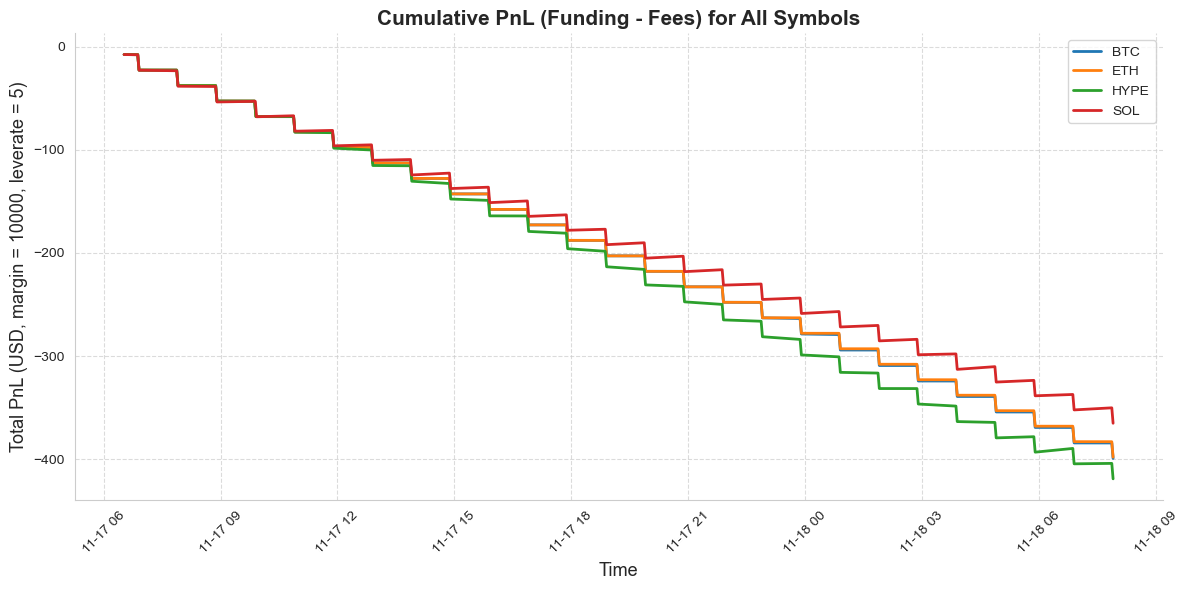

,symbol,position_id,status,opened_at,closed_at,hours_open,funding_pnl,fee_open,fee_close,total_pnl
0,BTC,1,closed,2025-11-17 06:31:25.973737,2025-11-17 06:53:25.979050,0.366668,-0.009167,7.5,7.5,-15.009167
1,BTC,2,closed,2025-11-17 06:54:25.979303,2025-11-17 07:53:25.992620,0.983337,-0.024583,7.5,7.5,-15.024583
2,BTC,3,closed,2025-11-17 07:54:25.992838,2025-11-17 08:53:26.005811,0.983337,-0.024583,7.5,7.5,-15.024583
3,BTC,4,closed,2025-11-17 08:54:26.006036,2025-11-17 09:53:26.018004,0.983337,-0.024583,7.5,7.5,-15.024583
4,BTC,5,closed,2025-11-17 09:54:26.018249,2025-11-17 10:53:26.030337,0.983337,-0.024583,7.5,7.5,-15.024583
...,...,...,...,...,...,...,...,...,...,...
103,SOL,23,closed,2025-11-18 03:54:26.271900,2025-11-18 04:53:26.285223,0.983337,2.679593,7.5,7.5,-12.320407
104,SOL,24,closed,2025-11-18 04:54:26.285474,2025-11-18 05:53:26.298585,0.983337,1.682136,7.5,7.5,-13.317864
105,SOL,25,closed,2025-11-18 05:54:26.298853,2025-11-18 06:53:26.312178,0.983337,1.296156,7.5,7.5,-13.703844
106,SOL,26,closed,2025-11-18 06:54:26.312443,2025-11-18 07:53:26.325372,0.983337,2.060828,7.5,7.5,-12.939172


In [30]:
# Cumulative PnL analysis: Insert path to the folder containing the CSV files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from glob import glob

# =============== User sets folder path here ===============
# Change this to your local folder path (only the folder, not the file)
CSV_FOLDER = "/Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/3_exit/"

# Find all CSV files in the folder
PATHS = sorted(glob(os.path.join(CSV_FOLDER, "*.csv")))

print(f"Found {len(PATHS)} CSV files in {CSV_FOLDER}:")
for p in PATHS:
    print("  -", os.path.basename(p))

all_pos_summary_rows = []
all_plot_data = []

for PATH in PATHS:
    # get symbol from file name
    fname = os.path.basename(PATH)
    # This regex captures BTC, ETH, SOL, HYPE, etc. from old_logs_BTC_..._decisions.csv
    match = re.search(r'logs_([A-Z]+)', fname)
    symbol = match.group(1) if match else fname

    df = pd.read_csv(PATH)

    # parse timestamp & sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # =========================
    # 2. Lọc bỏ enter/exit dư
    # =========================
    in_position = False
    keep = []

    for _, row in df.iterrows():
        action = row["action"]

        if action == "enter":
            if not in_position:
                keep.append(True)
                in_position = True
            else:
                # enter khi đã có position -> bỏ
                keep.append(False)

        elif action == "exit":
            if in_position:
                keep.append(True)
                in_position = False
            else:
                # exit khi đang flat -> bỏ
                keep.append(False)
        else:
            # hold / các action khác giữ nguyên
            keep.append(True)

    df = df.loc[keep].reset_index(drop=True)

    # =========================
    # 3. Chuẩn hóa funding rate
    # =========================
    df["y_funding_rate"] = df["y_funding_rate"] / 100.0

    # =========================
    # 4. Tính funding PnL (notional = 20,000) + fee
    # =========================
    NOTIONAL    = 50000.0
    FEE_RATE    = 0.015/100        # 0.015%
    FEE_PER_SIDE = NOTIONAL * FEE_RATE   # 3 USD

    records = []

    in_position      = False
    position_id      = 0
    last_ts          = None
    last_x_rate      = 0.0
    last_y_rate      = 0.0
    last_x_sign      = 0
    last_y_sign      = 0
    cum_funding_pos  = 0.0       # funding PnL tích lũy theo từng position

    for _, row in df.iterrows():
        ts      = row["timestamp"]
        action  = row["action"]
        x_sign  = 1 if row["x_is_long"] else -1
        y_sign  = 1 if row["y_is_long"] else -1

        # ----- funding cho đoạn (last_ts -> ts) -----
        dt_hours      = 0.0
        funding_step  = 0.0

        if last_ts is not None and in_position:
            dt_hours = (ts - last_ts).total_seconds() / 3600.0
            # net funding rate của pair trong khoảng trước đó
            net_rate_prev = -(last_x_sign * last_x_rate + last_y_sign * last_y_rate)
            funding_step  = net_rate_prev * dt_hours * NOTIONAL
            cum_funding_pos += funding_step

        # ----- update trạng thái position theo action hiện tại -----
        if action == "enter":
            position_id += 1          # bắt đầu position mới
            in_position = True
            cum_funding_pos = 0.0     # reset funding tích lũy cho position này

        elif action == "exit":
            # position đóng lại sau khi funding_step phía trên đã được tính
            in_position = False

        # ----- fee cho decision hiện tại -----
        fee_step = FEE_PER_SIDE if action in ("enter", "exit") else 0.0

        records.append({
            "timestamp": ts,
            "action": action,
            "position_id": position_id if position_id > 0 else pd.NA,
            "x_is_long": row["x_is_long"],
            "y_is_long": row["y_is_long"],
            "x_funding_rate": row["x_funding_rate"],
            "y_funding_rate": row["y_funding_rate"],
            "dt_hours": dt_hours,
            "funding_pnl_step": funding_step,        # funding PnL step (USD, margin = 10000, leverate = 5)
            "funding_pnl_cum_pos": cum_funding_pos,  # funding PnL tích lũy theo position
            "fee_step": fee_step,                    # fee (USD) tại decision này
            "symbol": symbol,                        # add symbol for later use
        })

        # chuẩn bị cho vòng tiếp theo
        last_ts     = ts
        last_x_rate = row["x_funding_rate"]
        last_y_rate = row["y_funding_rate"]
        last_x_sign = x_sign
        last_y_sign = y_sign

    df_pnl = pd.DataFrame(records)

    # PnL tổng (funding - fee) theo từng step + cumulative toàn thời gian
    df_pnl["total_pnl_step"] = df_pnl["funding_pnl_step"] - df_pnl["fee_step"]
    df_pnl["total_pnl_cum"]  = df_pnl["total_pnl_step"].cumsum()

    # Save plot data for multi-token plot
    all_plot_data.append({
        "symbol": symbol,
        "timestamps": df_pnl["timestamp"].values,
        "cumpnl": df_pnl["total_pnl_cum"].values,
    })

    # =========================
    # 5. Giữ lại các cột quan trọng / bỏ cột thừa
    # =========================
    df_pnl = df_pnl[
        [
            "timestamp",
            "action",
            "position_id",
            "x_is_long",
            "y_is_long",
            "x_funding_rate",
            "y_funding_rate",
            "dt_hours",
            "funding_pnl_step",
            "funding_pnl_cum_pos",
            "fee_step",
            "total_pnl_step",
            "total_pnl_cum",
            "symbol",
        ]
    ]

    # ------------------------
    # Generate PnL summary for this symbol
    pos_rows = []

    pos_df = df_pnl.dropna(subset=["position_id"]).copy()
    pos_df["position_id"] = pos_df["position_id"].astype(int)

    for pid, g in pos_df.groupby("position_id"):
        g = g.sort_values("timestamp")

        # tổng thời gian position mở (giờ), dùng dt_hours đã tính sẵn
        hours_open = g["dt_hours"].sum()

        funding_pnl = g["funding_pnl_step"].sum()      # funding PnL (USD)
        fee_open    = FEE_PER_SIDE if (g["action"] == "enter").any() else 0.0
        fee_close   = FEE_PER_SIDE if (g["action"] == "exit").any() else 0.0
        total_pnl   = funding_pnl - fee_open - fee_close  # same as g["total_pnl_step"].sum()

        has_exit = (g["action"] == "exit").any()
        status   = "closed" if has_exit else "open"

        opened_at = g.loc[g["action"] == "enter", "timestamp"].min() if (g["action"] == "enter").any() else pd.NaT
        closed_at = g.loc[g["action"] == "exit",  "timestamp"].max() if has_exit else pd.NaT

        pos_rows.append({
            "symbol": symbol,                    # Add symbol field for merged table
            "position_id": pid,
            "status": status,
            "opened_at": opened_at,
            "closed_at": closed_at,
            "hours_open": hours_open,      # <== new field
            "funding_pnl": funding_pnl,
            "fee_open": fee_open,
            "fee_close": fee_close,
            "total_pnl": total_pnl,
        })

    all_pos_summary_rows.extend(pos_rows)

# ============== Plot All tokens in one plot ==============
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=len(all_plot_data))
for i, pdict in enumerate(all_plot_data):
    plt.plot(
        pdict["timestamps"],
        pdict["cumpnl"],
        label=pdict["symbol"],
        linewidth=2,
        color=palette[i]
    )
plt.xlabel("Time", fontsize=13)
plt.ylabel("Total PnL (USD, margin = 10000, leverate = 5)", fontsize=13)
plt.title("Cumulative PnL (Funding - Fees) for All Symbols", fontsize=15, fontweight="bold")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='major', linestyle='--', alpha=0.7)
sns.despine()
plt.show()

# ============== Combine all summaries to one table ==============
pos_summary_all = pd.DataFrame(all_pos_summary_rows)
pos_summary_all = pos_summary_all.sort_values(["symbol", "position_id"]).reset_index(drop=True)
display(pos_summary_all)

# Test version 2 (Only Exit Liquidation)

Found 4 CSV files in /Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/Min_Dtl_only/:
  - logs_BTC_2025-11-17_SC_Min_Dtl_only_2_decisions.csv
  - logs_ETH_2025-11-17_SC_Min_Dtl_only_1_decisions.csv
  - logs_HYPE_2025-11-17_SC_Min_Dtl_only_4_decisions.csv
  - logs_SOL_2025-11-17_SC_Min_Dtl_only_3_decisions.csv


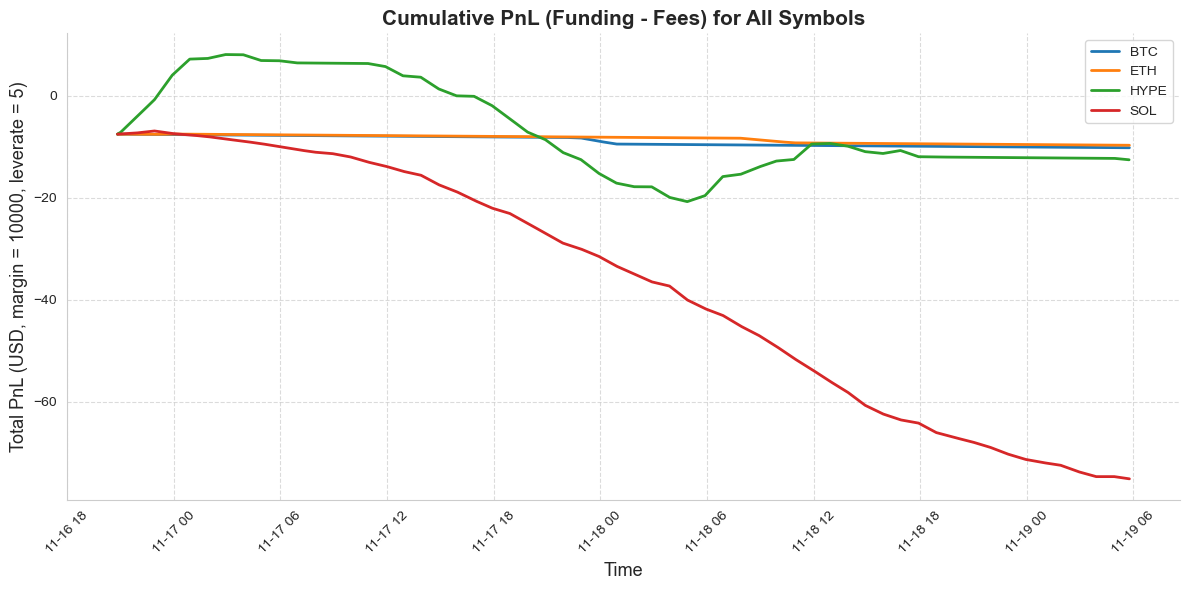

,symbol,position_id,status,opened_at,closed_at,hours_open,funding_pnl,fee_open,fee_close,total_pnl
0,BTC,1,open,2025-11-16 20:49:41.861784,NaT,56.950246,-2.663216,7.5,0.0,-10.163216
1,ETH,1,open,2025-11-16 20:49:42.041048,NaT,56.950237,-2.177664,7.5,0.0,-9.677664
2,HYPE,1,open,2025-11-16 20:49:42.082023,NaT,56.933558,-5.027189,7.5,0.0,-12.527189
3,SOL,1,open,2025-11-16 20:49:41.925254,NaT,56.950246,-67.612999,7.5,0.0,-75.112999


In [32]:
# Cumulative PnL analysis: Insert path to the folder containing the CSV files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from glob import glob

# =============== User sets folder path here ===============
# Change this to your local folder path (only the folder, not the file)
CSV_FOLDER = "/Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/Min_Dtl_only/"

# Find all CSV files in the folder
PATHS = sorted(glob(os.path.join(CSV_FOLDER, "*.csv")))

print(f"Found {len(PATHS)} CSV files in {CSV_FOLDER}:")
for p in PATHS:
    print("  -", os.path.basename(p))

all_pos_summary_rows = []
all_plot_data = []

for PATH in PATHS:
    # get symbol from file name
    fname = os.path.basename(PATH)
    # This regex captures BTC, ETH, SOL, HYPE, etc. from old_logs_BTC_..._decisions.csv
    match = re.search(r'logs_([A-Z]+)', fname)
    symbol = match.group(1) if match else fname

    df = pd.read_csv(PATH)

    # parse timestamp & sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # =========================
    # 2. Lọc bỏ enter/exit dư
    # =========================
    in_position = False
    keep = []

    for _, row in df.iterrows():
        action = row["action"]

        if action == "enter":
            if not in_position:
                keep.append(True)
                in_position = True
            else:
                # enter khi đã có position -> bỏ
                keep.append(False)

        elif action == "exit":
            if in_position:
                keep.append(True)
                in_position = False
            else:
                # exit khi đang flat -> bỏ
                keep.append(False)
        else:
            # hold / các action khác giữ nguyên
            keep.append(True)

    df = df.loc[keep].reset_index(drop=True)

    # =========================
    # 3. Chuẩn hóa funding rate
    # =========================
    df["y_funding_rate"] = df["y_funding_rate"] / 100.0

    # =========================
    # 4. Tính funding PnL (notional = 20,000) + fee
    # =========================
    NOTIONAL    = 50000.0
    FEE_RATE    = 0.015/100        # 0.015%
    FEE_PER_SIDE = NOTIONAL * FEE_RATE   # 3 USD

    records = []

    in_position      = False
    position_id      = 0
    last_ts          = None
    last_x_rate      = 0.0
    last_y_rate      = 0.0
    last_x_sign      = 0
    last_y_sign      = 0
    cum_funding_pos  = 0.0       # funding PnL tích lũy theo từng position

    for _, row in df.iterrows():
        ts      = row["timestamp"]
        action  = row["action"]
        x_sign  = 1 if row["x_is_long"] else -1
        y_sign  = 1 if row["y_is_long"] else -1

        # ----- funding cho đoạn (last_ts -> ts) -----
        dt_hours      = 0.0
        funding_step  = 0.0

        if last_ts is not None and in_position:
            dt_hours = (ts - last_ts).total_seconds() / 3600.0
            # net funding rate của pair trong khoảng trước đó
            net_rate_prev = -(last_x_sign * last_x_rate + last_y_sign * last_y_rate)
            funding_step  = net_rate_prev * dt_hours * NOTIONAL
            cum_funding_pos += funding_step

        # ----- update trạng thái position theo action hiện tại -----
        if action == "enter":
            position_id += 1          # bắt đầu position mới
            in_position = True
            cum_funding_pos = 0.0     # reset funding tích lũy cho position này

        elif action == "exit":
            # position đóng lại sau khi funding_step phía trên đã được tính
            in_position = False

        # ----- fee cho decision hiện tại -----
        fee_step = FEE_PER_SIDE if action in ("enter", "exit") else 0.0

        records.append({
            "timestamp": ts,
            "action": action,
            "position_id": position_id if position_id > 0 else pd.NA,
            "x_is_long": row["x_is_long"],
            "y_is_long": row["y_is_long"],
            "x_funding_rate": row["x_funding_rate"],
            "y_funding_rate": row["y_funding_rate"],
            "dt_hours": dt_hours,
            "funding_pnl_step": funding_step,        # funding PnL step (USD, margin = 10000, leverate = 5)
            "funding_pnl_cum_pos": cum_funding_pos,  # funding PnL tích lũy theo position
            "fee_step": fee_step,                    # fee (USD) tại decision này
            "symbol": symbol,                        # add symbol for later use
        })

        # chuẩn bị cho vòng tiếp theo
        last_ts     = ts
        last_x_rate = row["x_funding_rate"]
        last_y_rate = row["y_funding_rate"]
        last_x_sign = x_sign
        last_y_sign = y_sign

    df_pnl = pd.DataFrame(records)

    # PnL tổng (funding - fee) theo từng step + cumulative toàn thời gian
    df_pnl["total_pnl_step"] = df_pnl["funding_pnl_step"] - df_pnl["fee_step"]
    df_pnl["total_pnl_cum"]  = df_pnl["total_pnl_step"].cumsum()

    # Save plot data for multi-token plot
    all_plot_data.append({
        "symbol": symbol,
        "timestamps": df_pnl["timestamp"].values,
        "cumpnl": df_pnl["total_pnl_cum"].values,
    })

    # =========================
    # 5. Giữ lại các cột quan trọng / bỏ cột thừa
    # =========================
    df_pnl = df_pnl[
        [
            "timestamp",
            "action",
            "position_id",
            "x_is_long",
            "y_is_long",
            "x_funding_rate",
            "y_funding_rate",
            "dt_hours",
            "funding_pnl_step",
            "funding_pnl_cum_pos",
            "fee_step",
            "total_pnl_step",
            "total_pnl_cum",
            "symbol",
        ]
    ]

    # ------------------------
    # Generate PnL summary for this symbol
    pos_rows = []

    pos_df = df_pnl.dropna(subset=["position_id"]).copy()
    pos_df["position_id"] = pos_df["position_id"].astype(int)

    for pid, g in pos_df.groupby("position_id"):
        g = g.sort_values("timestamp")

        # tổng thời gian position mở (giờ), dùng dt_hours đã tính sẵn
        hours_open = g["dt_hours"].sum()

        funding_pnl = g["funding_pnl_step"].sum()      # funding PnL (USD)
        fee_open    = FEE_PER_SIDE if (g["action"] == "enter").any() else 0.0
        fee_close   = FEE_PER_SIDE if (g["action"] == "exit").any() else 0.0
        total_pnl   = funding_pnl - fee_open - fee_close  # same as g["total_pnl_step"].sum()

        has_exit = (g["action"] == "exit").any()
        status   = "closed" if has_exit else "open"

        opened_at = g.loc[g["action"] == "enter", "timestamp"].min() if (g["action"] == "enter").any() else pd.NaT
        closed_at = g.loc[g["action"] == "exit",  "timestamp"].max() if has_exit else pd.NaT

        pos_rows.append({
            "symbol": symbol,                    # Add symbol field for merged table
            "position_id": pid,
            "status": status,
            "opened_at": opened_at,
            "closed_at": closed_at,
            "hours_open": hours_open,      # <== new field
            "funding_pnl": funding_pnl,
            "fee_open": fee_open,
            "fee_close": fee_close,
            "total_pnl": total_pnl,
        })

    all_pos_summary_rows.extend(pos_rows)

# ============== Plot All tokens in one plot ==============
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=len(all_plot_data))
for i, pdict in enumerate(all_plot_data):
    plt.plot(
        pdict["timestamps"],
        pdict["cumpnl"],
        label=pdict["symbol"],
        linewidth=2,
        color=palette[i]
    )
plt.xlabel("Time", fontsize=13)
plt.ylabel("Total PnL (USD, margin = 10000, leverate = 5)", fontsize=13)
plt.title("Cumulative PnL (Funding - Fees) for All Symbols", fontsize=15, fontweight="bold")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='major', linestyle='--', alpha=0.7)
sns.despine()
plt.show()

# ============== Combine all summaries to one table ==============
pos_summary_all = pd.DataFrame(all_pos_summary_rows)
pos_summary_all = pos_summary_all.sort_values(["symbol", "position_id"]).reset_index(drop=True)
display(pos_summary_all)

# Test version 3 (Liquidation Exit  + Receiver Change )

Found 4 CSV files in /Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/2_Exit/:
  - logs_BTC_2025-11-17_SC_2_Exit_2_decisions.csv
  - logs_ETH_2025-11-17_SC_2_Exit_1_decisions.csv
  - logs_HYPE_2025-11-17_SC_2_Exit_4_decisions.csv
  - logs_SOL_2025-11-17_SC_2_Exit_3_decisions.csv


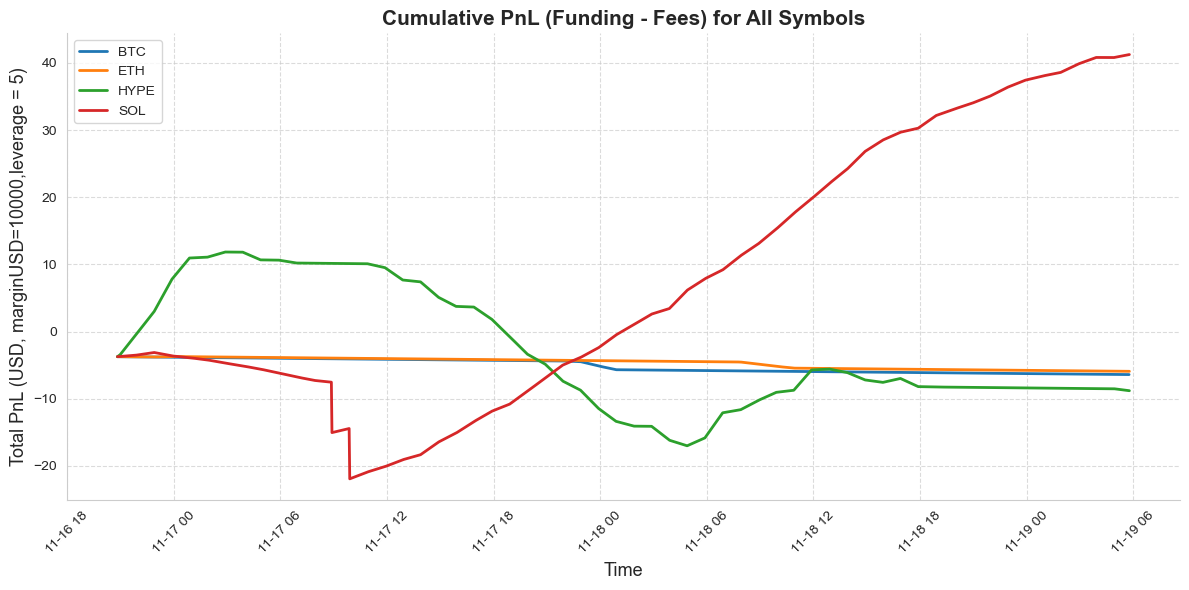

,symbol,position_id,status,opened_at,closed_at,hours_open,funding_pnl,fee_open,fee_close,total_pnl
0,BTC,1,open,2025-11-16 20:50:40.904297,NaT,56.916917,-2.662383,3.75,0.00,-6.412383
1,ETH,1,open,2025-11-16 20:50:40.809856,NaT,56.933586,-2.177247,3.75,0.00,-5.927247
2,HYPE,1,open,2025-11-16 20:50:40.819432,NaT,56.933584,-5.066189,3.75,0.00,-8.816189
3,SOL,1,closed,2025-11-16 20:50:40.861646,2025-11-17 08:53:41.199451,12.050094,-3.801676,3.75,3.75,-11.301676
4,SOL,2,closed,2025-11-17 08:54:41.199708,2025-11-17 09:53:41.213488,0.983337,0.614586,3.75,3.75,-6.885414
5,SOL,3,open,2025-11-17 09:54:41.213787,NaT,43.866831,63.172634,3.75,0.00,59.422634


In [34]:
# Cumulative PnL analysis: Insert path to the folder containing the CSV files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from glob import glob

# =============== User sets folder path here ===============
# Change this to your local folder path (only the folder, not the file)
CSV_FOLDER = "/Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v4/2025-11-17/2_Exit/"

# Find all CSV files in the folder
PATHS = sorted(glob(os.path.join(CSV_FOLDER, "*.csv")))

print(f"Found {len(PATHS)} CSV files in {CSV_FOLDER}:")
for p in PATHS:
    print("  -", os.path.basename(p))

all_pos_summary_rows = []
all_plot_data = []

for PATH in PATHS:
    # get symbol from file name
    fname = os.path.basename(PATH)
    # This regex captures BTC, ETH, SOL, HYPE, etc. from old_logs_BTC_..._decisions.csv
    match = re.search(r'logs_([A-Z]+)', fname)
    symbol = match.group(1) if match else fname

    df = pd.read_csv(PATH)

    # parse timestamp & sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # =========================
    # 2. Lọc bỏ enter/exit dư
    # =========================
    in_position = False
    keep = []

    for _, row in df.iterrows():
        action = row["action"]

        if action == "enter":
            if not in_position:
                keep.append(True)
                in_position = True
            else:
                # enter khi đã có position -> bỏ
                keep.append(False)

        elif action == "exit":
            if in_position:
                keep.append(True)
                in_position = False
            else:
                # exit khi đang flat -> bỏ
                keep.append(False)
        else:
            # hold / các action khác giữ nguyên
            keep.append(True)

    df = df.loc[keep].reset_index(drop=True)

    # =========================
    # 3. Chuẩn hóa funding rate
    # =========================
    df["y_funding_rate"] = df["y_funding_rate"] / 100.0

    # =========================
    # 4. Tính funding PnL (notional = 20,000) + fee
    # =========================
    NOTIONAL    = 50000.0
    FEE_RATE    = 1/2*0.015/100    # 0.015%
    FEE_PER_SIDE = NOTIONAL * FEE_RATE   # 3 USD

    records = []

    in_position      = False
    position_id      = 0
    last_ts          = None
    last_x_rate      = 0.0
    last_y_rate      = 0.0
    last_x_sign      = 0
    last_y_sign      = 0
    cum_funding_pos  = 0.0       # funding PnL tích lũy theo từng position

    for _, row in df.iterrows():
        ts      = row["timestamp"]
        action  = row["action"]
        x_sign  = 1 if row["x_is_long"] else -1
        y_sign  = 1 if row["y_is_long"] else -1

        # ----- funding cho đoạn (last_ts -> ts) -----
        dt_hours      = 0.0
        funding_step  = 0.0

        if last_ts is not None and in_position:
            dt_hours = (ts - last_ts).total_seconds() / 3600.0
            # net funding rate của pair trong khoảng trước đó
            net_rate_prev = -(last_x_sign * last_x_rate + last_y_sign * last_y_rate)
            funding_step  = net_rate_prev * dt_hours * NOTIONAL
            cum_funding_pos += funding_step

        # ----- update trạng thái position theo action hiện tại -----
        if action == "enter":
            position_id += 1          # bắt đầu position mới
            in_position = True
            cum_funding_pos = 0.0     # reset funding tích lũy cho position này

        elif action == "exit":
            # position đóng lại sau khi funding_step phía trên đã được tính
            in_position = False

        # ----- fee cho decision hiện tại -----
        fee_step = FEE_PER_SIDE if action in ("enter", "exit") else 0.0

        records.append({
            "timestamp": ts,
            "action": action,
            "position_id": position_id if position_id > 0 else pd.NA,
            "x_is_long": row["x_is_long"],
            "y_is_long": row["y_is_long"],
            "x_funding_rate": row["x_funding_rate"],
            "y_funding_rate": row["y_funding_rate"],
            "dt_hours": dt_hours,
            "funding_pnl_step": funding_step,        # funding PnL step (USD, margin = 10000, leverate = 5)
            "funding_pnl_cum_pos": cum_funding_pos,  # funding PnL tích lũy theo position
            "fee_step": fee_step,                    # fee (USD) tại decision này
            "symbol": symbol,                        # add symbol for later use
        })

        # chuẩn bị cho vòng tiếp theo
        last_ts     = ts
        last_x_rate = row["x_funding_rate"]
        last_y_rate = row["y_funding_rate"]
        last_x_sign = x_sign
        last_y_sign = y_sign

    df_pnl = pd.DataFrame(records)

    # PnL tổng (funding - fee) theo từng step + cumulative toàn thời gian
    df_pnl["total_pnl_step"] = df_pnl["funding_pnl_step"] - df_pnl["fee_step"]
    df_pnl["total_pnl_cum"]  = df_pnl["total_pnl_step"].cumsum()

    # Save plot data for multi-token plot
    all_plot_data.append({
        "symbol": symbol,
        "timestamps": df_pnl["timestamp"].values,
        "cumpnl": df_pnl["total_pnl_cum"].values,
    })

    # =========================
    # 5. Giữ lại các cột quan trọng / bỏ cột thừa
    # =========================
    df_pnl = df_pnl[
        [
            "timestamp",
            "action",
            "position_id",
            "x_is_long",
            "y_is_long",
            "x_funding_rate",
            "y_funding_rate",
            "dt_hours",
            "funding_pnl_step",
            "funding_pnl_cum_pos",
            "fee_step",
            "total_pnl_step",
            "total_pnl_cum",
            "symbol",
        ]
    ]

    # ------------------------
    # Generate PnL summary for this symbol
    pos_rows = []

    pos_df = df_pnl.dropna(subset=["position_id"]).copy()
    pos_df["position_id"] = pos_df["position_id"].astype(int)

    for pid, g in pos_df.groupby("position_id"):
        g = g.sort_values("timestamp")

        # tổng thời gian position mở (giờ), dùng dt_hours đã tính sẵn
        hours_open = g["dt_hours"].sum()

        funding_pnl = g["funding_pnl_step"].sum()      # funding PnL (USD)
        fee_open    = FEE_PER_SIDE if (g["action"] == "enter").any() else 0.0
        fee_close   = FEE_PER_SIDE if (g["action"] == "exit").any() else 0.0
        total_pnl   = funding_pnl - fee_open - fee_close  # same as g["total_pnl_step"].sum()

        has_exit = (g["action"] == "exit").any()
        status   = "closed" if has_exit else "open"

        opened_at = g.loc[g["action"] == "enter", "timestamp"].min() if (g["action"] == "enter").any() else pd.NaT
        closed_at = g.loc[g["action"] == "exit",  "timestamp"].max() if has_exit else pd.NaT

        pos_rows.append({
            "symbol": symbol,                    # Add symbol field for merged table
            "position_id": pid,
            "status": status,
            "opened_at": opened_at,
            "closed_at": closed_at,
            "hours_open": hours_open,      # <== new field
            "funding_pnl": funding_pnl,
            "fee_open": fee_open,
            "fee_close": fee_close,
            "total_pnl": total_pnl,
        })

    all_pos_summary_rows.extend(pos_rows)

# ============== Plot All tokens in one plot ==============
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=len(all_plot_data))
for i, pdict in enumerate(all_plot_data):
    plt.plot(
        pdict["timestamps"],
        pdict["cumpnl"],
        label=pdict["symbol"],
        linewidth=2,
        color=palette[i]
    )
plt.xlabel("Time", fontsize=13)
plt.ylabel("Total PnL (USD, marginUSD=10000,leverage = 5)", fontsize=13)
plt.title("Cumulative PnL (Funding - Fees) for All Symbols", fontsize=15, fontweight="bold")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='major', linestyle='--', alpha=0.7)
sns.despine()
plt.show()

# ============== Combine all summaries to one table ==============
pos_summary_all = pd.DataFrame(all_pos_summary_rows)
pos_summary_all = pos_summary_all.sort_values(["symbol", "position_id"]).reset_index(drop=True)
display(pos_summary_all)

# Test 4 (Mix conditions)

Found 4 CSV files in /Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v3/4_exits:
  - logs_BTC_2025-11-17_SC_mixed_exits_2_decisions.csv
  - logs_ETH_2025-11-17_SC_mixed_exits_1_decisions.csv
  - logs_HYPE_2025-11-17_SC_mixed_exits_4_decisions.csv
  - logs_SOL_2025-11-17_SC_mixed_exits_3_decisions.csv


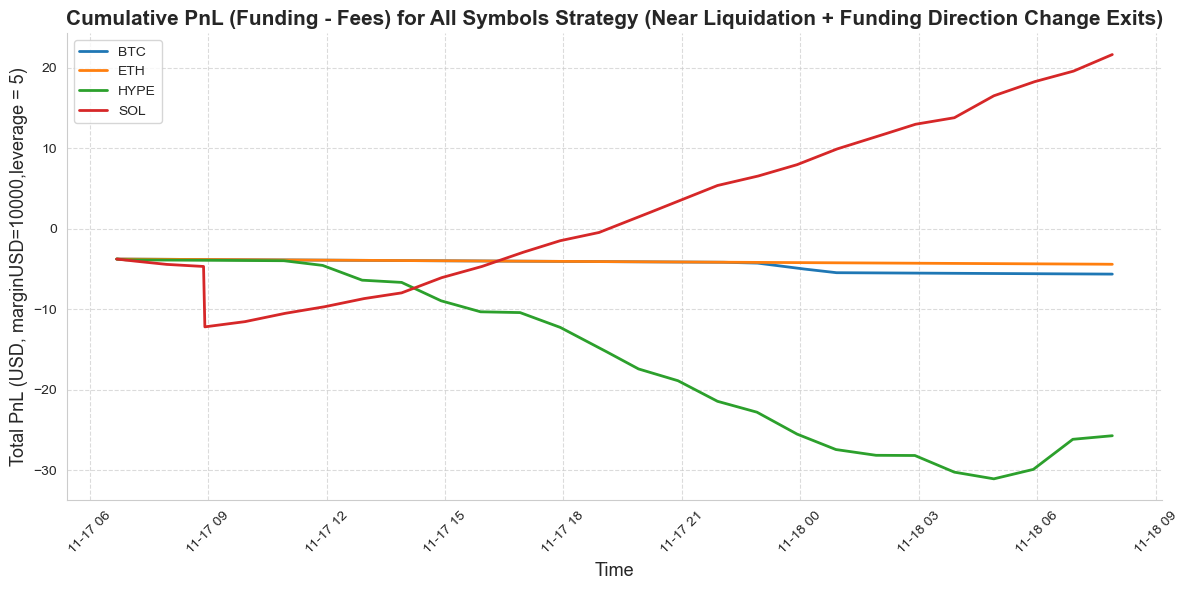

,symbol,position_id,status,opened_at,closed_at,hours_open,funding_pnl,fee_open,fee_close,total_pnl
0,BTC,1,open,2025-11-17 06:41:02.778009,NaT,25.216771,-1.869879,3.75,0.00,-5.619879
1,ETH,1,open,2025-11-17 06:41:02.806885,NaT,25.216763,-0.648889,3.75,0.00,-4.398889
2,HYPE,1,open,2025-11-17 06:41:02.914291,NaT,25.216766,-21.951591,3.75,0.00,-25.701591
3,SOL,1,closed,2025-11-17 06:41:02.939385,2025-11-17 08:54:02.971625,2.216676,-0.924587,3.75,3.75,-8.424587
4,SOL,2,open,2025-11-17 08:55:02.971942,NaT,22.983423,33.835380,3.75,0.00,30.085380


In [ ]:
# Cumulative PnL analysis: Insert path to the folder containing the CSV files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from glob import glob

# =============== User sets folder path here ===============
# Change this to your local folder path (only the folder, not the file)
CSV_FOLDER = "/Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v3/4_exits"

# Find all CSV files in the folder
PATHS = sorted(glob(os.path.join(CSV_FOLDER, "*.csv")))

print(f"Found {len(PATHS)} CSV files in {CSV_FOLDER}:")
for p in PATHS:
    print("  -", os.path.basename(p))

all_pos_summary_rows = []
all_plot_data = []

for PATH in PATHS:
    # get symbol from file name
    fname = os.path.basename(PATH)
    # This regex captures BTC, ETH, SOL, HYPE, etc. from old_logs_BTC_..._decisions.csv
    match = re.search(r'logs_([A-Z]+)', fname)
    symbol = match.group(1) if match else fname

    df = pd.read_csv(PATH)

    # parse timestamp & sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # =========================
    # 2. Lọc bỏ enter/exit dư
    # =========================
    in_position = False
    keep = []

    for _, row in df.iterrows():
        action = row["action"]

        if action == "enter":
            if not in_position:
                keep.append(True)
                in_position = True
            else:
                # enter khi đã có position -> bỏ
                keep.append(False)

        elif action == "exit":
            if in_position:
                keep.append(True)
                in_position = False
            else:
                # exit khi đang flat -> bỏ
                keep.append(False)
        else:
            # hold / các action khác giữ nguyên
            keep.append(True)

    df = df.loc[keep].reset_index(drop=True)

    # =========================
    # 3. Chuẩn hóa funding rate
    # =========================
    df["y_funding_rate"] = df["y_funding_rate"] / 100.0

    # =========================
    # 4. Tính funding PnL (notional = 20,000) + fee
    # =========================
    NOTIONAL    = 50000.0
    FEE_RATE    = 0.015/100    # 0.015%
    FEE_PER_SIDE = NOTIONAL * FEE_RATE   # 3 USD

    records = []

    in_position      = False
    position_id      = 0
    last_ts          = None
    last_x_rate      = 0.0
    last_y_rate      = 0.0
    last_x_sign      = 0
    last_y_sign      = 0
    cum_funding_pos  = 0.0       # funding PnL tích lũy theo từng position

    for _, row in df.iterrows():
        ts      = row["timestamp"]
        action  = row["action"]
        x_sign  = 1 if row["x_is_long"] else -1
        y_sign  = 1 if row["y_is_long"] else -1

        # ----- funding cho đoạn (last_ts -> ts) -----
        dt_hours      = 0.0
        funding_step  = 0.0

        if last_ts is not None and in_position:
            dt_hours = (ts - last_ts).total_seconds() / 3600.0
            # net funding rate của pair trong khoảng trước đó
            net_rate_prev = -(last_x_sign * last_x_rate + last_y_sign * last_y_rate)
            funding_step  = net_rate_prev * dt_hours * NOTIONAL
            cum_funding_pos += funding_step

        # ----- update trạng thái position theo action hiện tại -----
        if action == "enter":
            position_id += 1          # bắt đầu position mới
            in_position = True
            cum_funding_pos = 0.0     # reset funding tích lũy cho position này

        elif action == "exit":
            # position đóng lại sau khi funding_step phía trên đã được tính
            in_position = False

        # ----- fee cho decision hiện tại -----
        fee_step = FEE_PER_SIDE if action in ("enter", "exit") else 0.0

        records.append({
            "timestamp": ts,
            "action": action,
            "position_id": position_id if position_id > 0 else pd.NA,
            "x_is_long": row["x_is_long"],
            "y_is_long": row["y_is_long"],
            "x_funding_rate": row["x_funding_rate"],
            "y_funding_rate": row["y_funding_rate"],
            "dt_hours": dt_hours,
            "funding_pnl_step": funding_step,        # funding PnL step (USD, margin = 10000, leverate = 5)
            "funding_pnl_cum_pos": cum_funding_pos,  # funding PnL tích lũy theo position
            "fee_step": fee_step,                    # fee (USD) tại decision này
            "symbol": symbol,                        # add symbol for later use
        })

        # chuẩn bị cho vòng tiếp theo
        last_ts     = ts
        last_x_rate = row["x_funding_rate"]
        last_y_rate = row["y_funding_rate"]
        last_x_sign = x_sign
        last_y_sign = y_sign

    df_pnl = pd.DataFrame(records)

    # PnL tổng (funding - fee) theo từng step + cumulative toàn thời gian
    df_pnl["total_pnl_step"] = df_pnl["funding_pnl_step"] - df_pnl["fee_step"]
    df_pnl["total_pnl_cum"]  = df_pnl["total_pnl_step"].cumsum()

    # Save plot data for multi-token plot
    all_plot_data.append({
        "symbol": symbol,
        "timestamps": df_pnl["timestamp"].values,
        "cumpnl": df_pnl["total_pnl_cum"].values,
    })

    # =========================
    # 5. Giữ lại các cột quan trọng / bỏ cột thừa
    # =========================
    df_pnl = df_pnl[
        [
            "timestamp",
            "action",
            "position_id",
            "x_is_long",
            "y_is_long",
            "x_funding_rate",
            "y_funding_rate",
            "dt_hours",
            "funding_pnl_step",
            "funding_pnl_cum_pos",
            "fee_step",
            "total_pnl_step",
            "total_pnl_cum",
            "symbol",
        ]
    ]

    # ------------------------
    # Generate PnL summary for this symbol
    pos_rows = []

    pos_df = df_pnl.dropna(subset=["position_id"]).copy()
    pos_df["position_id"] = pos_df["position_id"].astype(int)

    for pid, g in pos_df.groupby("position_id"):
        g = g.sort_values("timestamp")

        # tổng thời gian position mở (giờ), dùng dt_hours đã tính sẵn
        hours_open = g["dt_hours"].sum()

        funding_pnl = g["funding_pnl_step"].sum()      # funding PnL (USD)
        fee_open    = FEE_PER_SIDE if (g["action"] == "enter").any() else 0.0
        fee_close   = FEE_PER_SIDE if (g["action"] == "exit").any() else 0.0
        total_pnl   = funding_pnl - fee_open - fee_close  # same as g["total_pnl_step"].sum()

        has_exit = (g["action"] == "exit").any()
        status   = "closed" if has_exit else "open"

        opened_at = g.loc[g["action"] == "enter", "timestamp"].min() if (g["action"] == "enter").any() else pd.NaT
        closed_at = g.loc[g["action"] == "exit",  "timestamp"].max() if has_exit else pd.NaT

        pos_rows.append({
            "symbol": symbol,                    # Add symbol field for merged table
            "position_id": pid,
            "status": status,
            "opened_at": opened_at,
            "closed_at": closed_at,
            "hours_open": hours_open,      # <== new field
            "funding_pnl": funding_pnl,
            "fee_open": fee_open,
            "fee_close": fee_close,
            "total_pnl": total_pnl,
        })

    all_pos_summary_rows.extend(pos_rows)

# ============== Plot All tokens in one plot ==============
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", n_colors=len(all_plot_data))
for i, pdict in enumerate(all_plot_data):
    plt.plot(
        pdict["timestamps"],
        pdict["cumpnl"],
        label=pdict["symbol"],
        linewidth=2,
        color=palette[i]
    )
plt.xlabel("Time", fontsize=13)
plt.ylabel("Total PnL (USD, marginUSD=10000,leverage = 5)", fontsize=13)
plt.title("Cumulative PnL (Funding - Fees) for All Symbols Strategy (Near Liquidation + Funding Direction Change Exits)", fontsize=15, fontweight="bold")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='major', linestyle='--', alpha=0.7)
sns.despine()
plt.show()

# ============== Combine all summaries to one table ==============
pos_summary_all = pd.DataFrame(all_pos_summary_rows)
pos_summary_all = pos_summary_all.sort_values(["symbol", "position_id"]).reset_index(drop=True)
display(pos_summary_all)

# Analysis the price 

Loading logs_BTC_2025-11-17_SC_2_Exit_2_decisions.csv for token BTC...


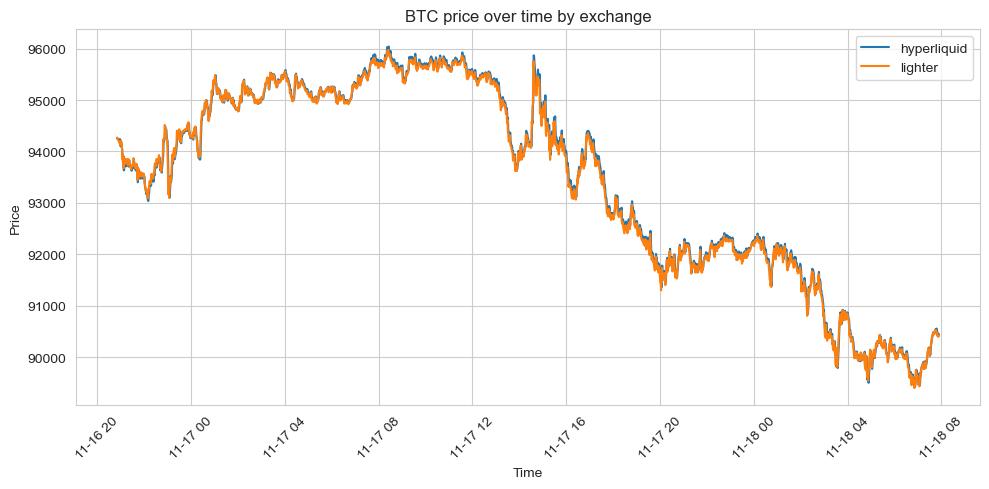

Loading logs_ETH_2025-11-17_SC_2_Exit_1_decisions.csv for token ETH...


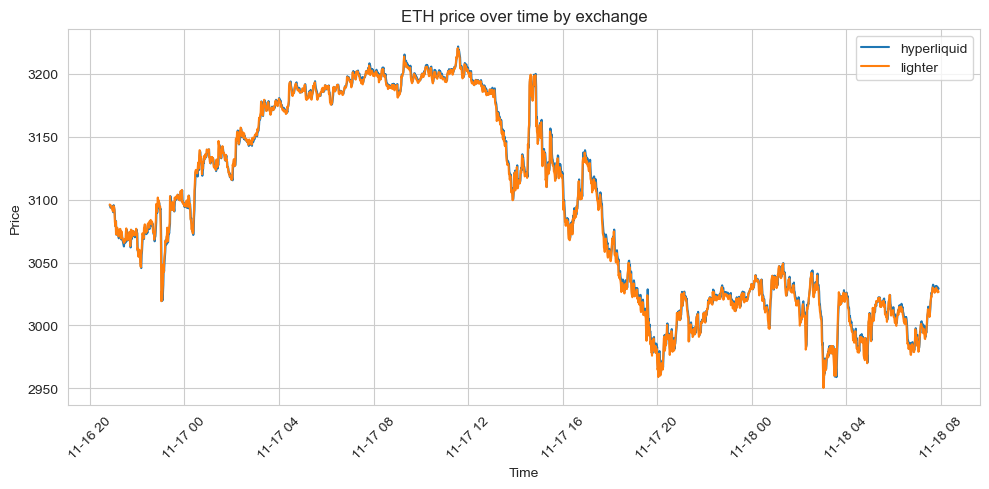

Loading logs_HYPE_2025-11-17_SC_2_Exit_4_decisions.csv for token HYPE...


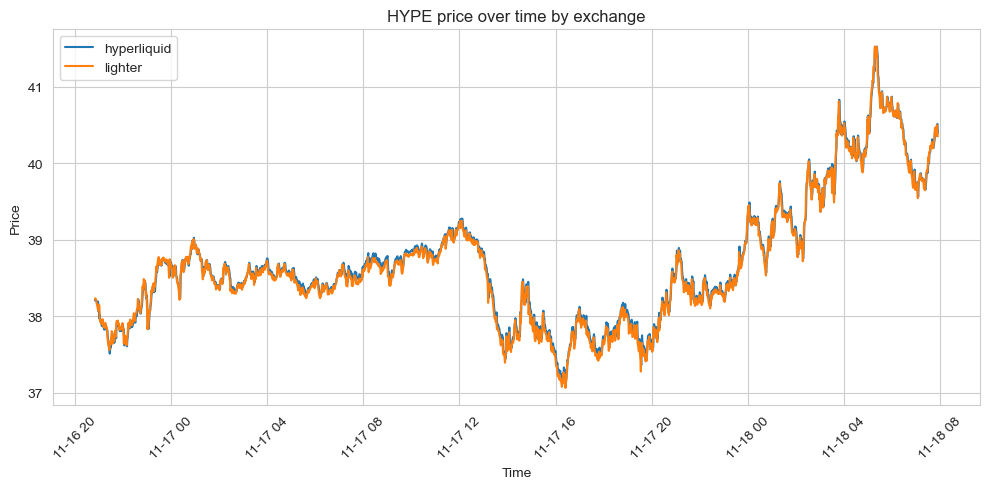

Loading logs_SOL_2025-11-17_SC_2_Exit_3_decisions.csv for token SOL...


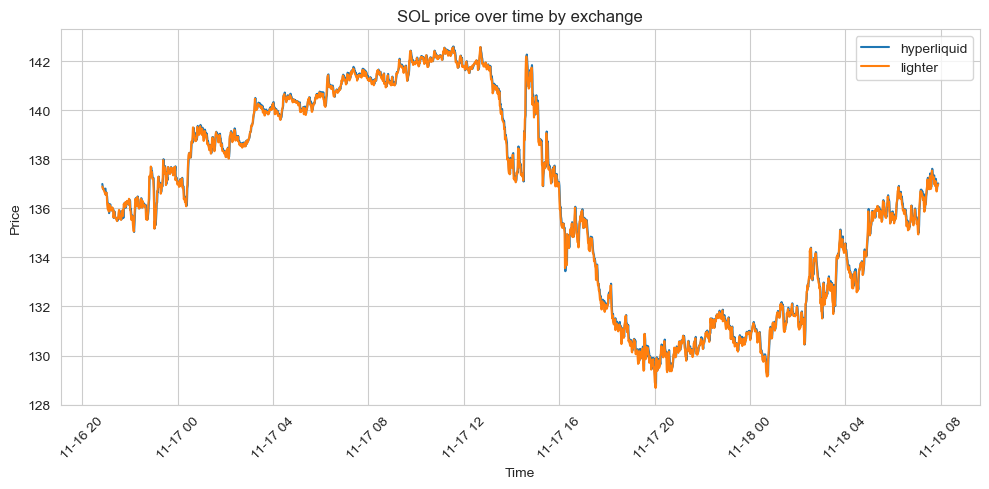

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# 1. Config: folder path
# =========================
# 👉 Change this to your local folder that contains ONLY the CSVs
FOLDER = Path("/Users/trancatkhanh/Downloads/Monitor PNL/decisions_output_v3/2_exits")  # e.g. Path("/Users/you/Monitor PNL/decisions_output")


# =========================
# 2. Helper: infer token symbol from filename
#    Example: "logs_new_ETH_2025-11-09_decisions.csv" -> "ETH"
# =========================
def infer_token_symbol(file_path: Path) -> str:
    name = file_path.stem  # filename without .csv
    parts = name.split("_")
    # Try to pick the first obvious token-looking part (all caps, letters)
    candidates = [p for p in parts if p.isalpha() and p.upper() == p]
    if candidates:
        return candidates[0]
    # fallback: just use the stem
    return name


# =========================
# 3. Helper: plot price per token & exchange
# =========================
def plot_token_prices(file_path: Path, token_symbol: str):
    print(f"Loading {file_path.name} for token {token_symbol}...")
    df = pd.read_csv(file_path)

    # Basic column check
    required_cols = {"timestamp", "x_exchange", "y_exchange", "x_price", "y_price"}
    missing = required_cols - set(df.columns)
    if missing:
        print(f"⚠️ Skip {file_path.name}: missing columns {missing}")
        return

    # Parse time & sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Long format: one row per (timestamp, exchange, price)
    df_x = df[["timestamp", "x_exchange", "x_price"]].rename(
        columns={"x_exchange": "exchange", "x_price": "price"}
    )
    df_y = df[["timestamp", "y_exchange", "y_price"]].rename(
        columns={"y_exchange": "exchange", "y_price": "price"}
    )

    df_long = pd.concat([df_x, df_y], ignore_index=True)

    # Plot: one line per exchange
    plt.figure(figsize=(10, 5))
    for ex, g in df_long.groupby("exchange"):
        g = g.sort_values("timestamp")
        plt.plot(g["timestamp"], g["price"], label=ex)

    plt.title(f"{token_symbol} price over time by exchange")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# 4. Loop over all CSVs in the folder
# =========================
csv_files = sorted(FOLDER.glob("*.csv"))

if not csv_files:
    print(f"No CSV files found in folder: {FOLDER}")
else:
    for csv_path in csv_files:
        token = infer_token_symbol(csv_path)
        plot_token_prices(csv_path, token)